In [29]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import time

# import models
# import train_lstm

In [30]:
# import importlib
# importlib.reload(train_lstm)
# importlib.reload(models)

## Define Model

In [31]:
seed = 1289719
series_min_len = 144 #12hrs
pred_horizon = 12 # 1hr
input_size = series_min_len - pred_horizon
output_size = pred_horizon
import math
dataset_path = '../timeseries_0-patients_step-1_len-x.pkl'

# group_id = 2
# dataset_path = "timeseries_"+str(group_id)+"-patients_step-1.pkl"

In [32]:
epochs = 20
batch_size = 128
learning_rate = 0.001
save_every = 1
test_every = save_every

epoch_start = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

# lstm_trainer = train_lstm.LSTM_Trainer(seed, device)

# heurisitic = models.Heuristic(1, 1).to(device)
loss_func = nn.MSELoss()

No GPU available, training on CPU; consider making n_epochs very small.


## Copy Last

In [33]:
# #load test set
# lstm_trainer.load_test(dataset_path, 1, input_size, pred_horizon, 0)
# data_loader = lstm_trainer.test_loader

In [34]:
# num_batches = len(data_loader)
# print(num_batches)
# total_loss = 0


# start = time.time()
# esod = 0
# for X, y in data_loader:
#     last = X[0][-1]
#     prediction_full = last.repeat(1,pred_horizon)
#     #MSE
#     total_loss += loss_func(prediction_full, y).item()

#     #ESOD
#     # esod_pred = 0
#     # esod_y = 0
#     # preds = prediction_full.cpu().detach().numpy()[0]
#     # y_t = y.cpu().detach().numpy()[0]
#     # for j in range(2, len(preds)):
#     #     esod_pred += math.pow((preds[j] - 2*preds[j-1] + preds[j-2]), 2)
#     #     esod_y += math.pow((y_t[j] - 2*y_t[j-1] + y_t[j-2]), 2)
#     # if (esod_y != 0):
#     #     esod += esod_pred / esod_y
#     # break

# end = time.time()

# avg_loss = total_loss / num_batches
# print(f"Test loss: {avg_loss}")
# print("avg ESOD:", esod/num_batches)

# print("Time: ", end-start)


## Linear Regression

In [35]:
import pickle
[X_train, X_test, y_train, y_test] = pickle.load(open(dataset_path, 'rb'))

### Hyperparameter Tuning
* learning rate
* number of iterations
* last n of samples to use for prediction
* order of polynomial (1-5)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# epochs = len(X_test)
epochs = 1000


num_batches = len(X_test)
print(num_batches)
total_loss = 0
esod = 0

input_size = 5 

# array to store the loss values for each hyperparameter combination
losses = []
min_loss = 99999999999

# hyperparameters to try for higher order regression
# learning_rates = [0.001, 0.01, 0.1]
degrees = [1, 2, 3, 4, 5, 6]
last_n_steps = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


start = time.time()


for last_n in last_n_steps:
        
    for degree in degrees:
        # degree = 1
        # last_n = 5

    
        for i in range(0,epochs):
                X = X_test[i]
                y = y_test[i]

                last = X[-last_n:] 
                input_size = last_n
                
                # prediction_full = last.repeat(1,pred_horizon)
                
                # reg = LinearRegression().fit(np.arange(0,input_size,1).reshape(input_size,1), last)
                
                
                # m, c = np.linalg.lstsq(range(0,5), last)
                # preds = m * np.linspace(6, 6+12, 1) + c

                # preds = reg.predict(np.arange(input_size,input_size+pred_horizon,1).reshape(pred_horizon,1))

                # Polynomial Regression
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(np.arange(0,input_size,1).reshape(input_size,1))
                poly.fit(X_poly, last)
                lin2 = LinearRegression()
                lin2.fit(X_poly, last)
                preds = lin2.predict(poly.fit_transform(np.arange(input_size,input_size+pred_horizon,1).reshape(pred_horizon,1)))

                #MSE
                prediction_full = torch.Tensor(preds.squeeze())
                y_t = torch.Tensor(y)
                loss = loss_func(prediction_full.squeeze(), y_t).item()
                total_loss += loss

                #ESOD
                esod_pred = 0
                esod_y = 0
                preds2 = preds.squeeze()
                for j in range(2, len(preds2)):
                    esod_pred += math.pow((preds2[j] - 2*preds2[j-1] + preds2[j-2]), 2)
                    esod_y += math.pow((y[j] - 2*y[j-1] + y[j-2]), 2)
                if (esod_y != 0):
                    esod += esod_pred / esod_y

        # get the best hyperparameters for this epoch
        losses.append(total_loss)
        if (total_loss < min_loss):
            min_loss = total_loss
            best_degree = degree
            best_last_n = last_n
            best_reg = lin2
    
        print("Loss: ", total_loss)
        total_loss = 0

end = time.time()

print("Min Losses: ", min(losses))
print("RMSE: ", math.sqrt(min(losses)))
print("Best Degree: ", best_degree)
print("Best Last N: ", best_last_n)


avg_loss = total_loss / epochs
print(f"Test loss: {avg_loss}")
print("avg ESOD:", esod/num_batches)

print("Time: ", end-start)





52329
Loss:  1782778.6450783014
Loss:  15217933.931875706
Loss:  606714016.1204767
Loss:  87985938120.84615
Loss:  2652093827593.057
Loss:  184693853081555.47
Loss:  2037466.7599680424
Loss:  7744267.622604489
Loss:  68956195.84585094
Loss:  948687720.468853
Loss:  28893472952.84382
Loss:  899872243519.6237
Loss:  2354296.4026720524
Loss:  6142038.504704714
Loss:  35232292.61674237
Loss:  253994679.0650344
Loss:  2744416529.455143
Loss:  40741268219.016235
Loss:  2694981.563713491
Loss:  5518923.653866291
Loss:  21838617.95465851
Loss:  136311362.0193615
Loss:  848705996.7437763
Loss:  8024036031.508118
Loss:  2951525.814533353
Loss:  5022142.880075812
Loss:  17953062.41411662
Loss:  76083686.01341534
Loss:  465277144.72181034
Loss:  2512277019.796875
Loss:  3127802.510220468
Loss:  5055783.570047498
Loss:  14749365.084583282
Loss:  55755593.83332682
Loss:  255439444.78483963
Loss:  1442752648.284645
Loss:  3370642.7976415753
Loss:  5522654.340210795
Loss:  12109559.812122345
Loss:  43

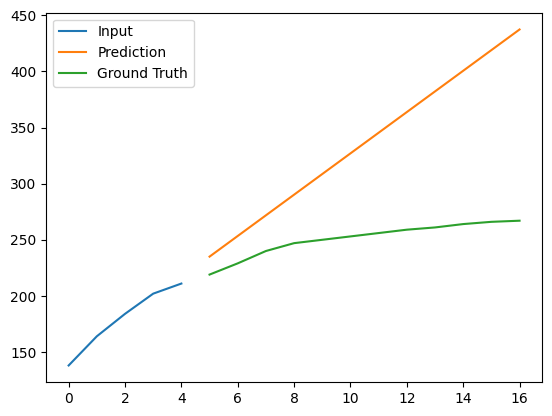

[[1.78277865e+06 1.52179339e+07 6.06714016e+08 8.79859381e+10
  2.65209383e+12 1.84693853e+14]
 [2.03746676e+06 7.74426762e+06 6.89561958e+07 9.48687720e+08
  2.88934730e+10 8.99872244e+11]
 [2.35429640e+06 6.14203850e+06 3.52322926e+07 2.53994679e+08
  2.74441653e+09 4.07412682e+10]
 [2.69498156e+06 5.51892365e+06 2.18386180e+07 1.36311362e+08
  8.48705997e+08 8.02403603e+09]
 [2.95152581e+06 5.02214288e+06 1.79530624e+07 7.60836860e+07
  4.65277145e+08 2.51227702e+09]
 [3.12780251e+06 5.05578357e+06 1.47493651e+07 5.57555938e+07
  2.55439445e+08 1.44275265e+09]
 [3.37064280e+06 5.52265434e+06 1.21095598e+07 4.31727938e+07
  1.71011545e+08 7.78068465e+08]
 [3.62387180e+06 5.53627190e+06 1.02974312e+07 3.83568324e+07
  1.22928943e+08 4.98131060e+08]
 [3.82488609e+06 5.50235473e+06 1.03655097e+07 3.08531962e+07
  9.21709128e+07 3.72322044e+08]
 [4.01707698e+06 5.51227075e+06 1.05068583e+07 2.37965953e+07
  8.44535442e+07 2.56387808e+08]]
Losses:
               1             2           

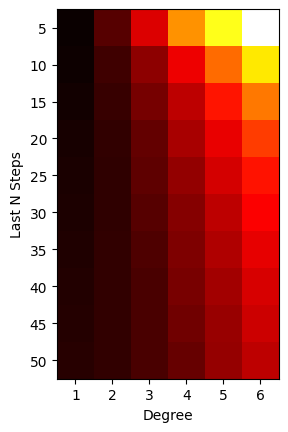

In [52]:
# Print RMSE/epoch for each hyperparameter 
print("RMSE: ", math.sqrt(min(losses)))



# Plotting an example of the best hyperparameter combination
X = X_test[0]
y = y_test[0]

degree = best_degree
last_n = best_last_n

last = X[-last_n:]
input_size = last_n

reg = LinearRegression().fit(np.arange(0,input_size,1).reshape(input_size,1), last)
preds = reg.predict(np.arange(input_size,input_size+pred_horizon,1).reshape(pred_horizon,1))

plt.plot(np.arange(0,input_size,1), last, label="Input")
plt.plot(np.arange(input_size,input_size+pred_horizon,1), preds, label="Prediction")
plt.plot(np.arange(input_size,input_size+pred_horizon,1), y, label="Ground Truth")
plt.legend()
plt.show()


# convert loss array to heatmap
losses = np.array(losses)
# degrees is in the inner loop and last_n_steps is in the outer loop
# so we need to reshape the array to match the order of the loops
losses = losses.reshape(len(last_n_steps), len(degrees))
print(losses)

# # normalize the losses and remove outliers
# log scaling
log_losses = np.log(losses)
# print in df form
print("Losses:")
import pandas as pd
print(pd.DataFrame(losses, index=last_n_steps, columns=degrees))


# set axis labels
plt.xlabel('Degree')
plt.ylabel('Last N Steps')
# set axis
plt.xticks(np.arange(len(degrees)), degrees)
plt.yticks(np.arange(len(last_n_steps)), last_n_steps)

# plot the heatmap
plt.imshow(log_losses, cmap='hot', interpolation='nearest')
plt.show()


# plot the best regression line best_reg on the scatter plot
# draw scatter plot of all the points
# plt.scatter(np.arange(0,input_size,1), last, label="Input")
# # draw the best regression line
# plt.plot(np.arange(0,input_size,1), best_reg.predict(poly.fit_transform(np.arange(0,input_size,1).reshape(input_size,1))), label="Best Regression Line")
# plt.legend()

# plt.show()


# ARIMA Model

In [ ]:
# arima imports
import pmdarima as pm
from pmdarima import model_selection, pipeline ,arima, metrics
from pmdarima import preprocessing as ppc

In [68]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# # Assuming X_train is a 2D array containing multiple time segments from many patients
# # X_train should be in the shape (n_samples, n_features)

# # Split the data into training and test sets
# train_data = X_train[:-12]
# test_data = X_train[-12:]

# # Determine the appropriate order of differencing, autoregression, and moving average terms
# d = 1
# p = 2
# q = 1

# # Create an instance of the ARIMA model
# model = ARIMA(train_data, order=(p, d, q))

# # Fit the model to the training data
# model_fit = model.fit()

# # Generate forecasts for the test data
# forecast = model_fit.forecast(steps=12)[0]

# # Evaluate the accuracy of the model
# mse = mean_squared_error(test_data, forecast)
# print('Mean squared error:', mse)


In [ ]:
# plot arima preds
plt.plot(np.arange(0,pred_horizon,1), arima_preds, label="Prediction")
plt.plot(np.arange(0,pred_horizon,1), y_test[0], label="Ground Truth")  
plt.legend()
plt.show()

# print arima score
print("ARIMA Score: ", arima_score)


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

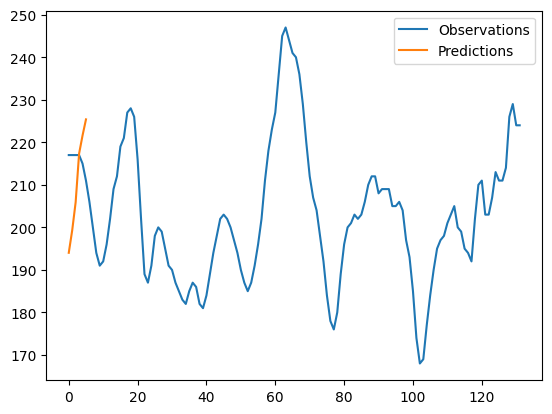

In [73]:
# Create ARIMA model
data = X_train[0]

# Create ARIMA model
model = ARIMA(data, order=(2,1,0)) # ARIMA(2,1,0) model
model_fit = model.fit()

# Plot forecasted values
fig, ax = plt.subplots()
ax.plot(data, label='Observations')
ax.plot(model_fit.predict(start=11*5, end=12*5), label='Predictions')
ax.legend()
plt.show()


